# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
# from mlagents_envs.environment import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Defining a Model

Basic implementation of DNN with just 3 hidden layers for further usage as the target and local netwrorks

DQN defines Q-function as a neural network that maps State to Action

For the current environment the following archetecture was chosen:
```
    Input
      |
    _/ Linear(128)
      |
    _/ Linear(512)
      |
    _/ Linear(256)
      |
    Output
```
Where `_/` - ReLu

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from torch import nn
import torch.nn.functional as f

class Net(nn.Module):
    """
    Simple Network of Linear layers
    """
    
    def __init__(self, inputs, outputs, device='cpu', dims=(128, 512, 256)):
        super(Net, self).__init__()
        self.activation = nn.ReLU()
        
        self.input = nn.Linear(inputs, dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.hidden_layers.append(nn.Linear(dims[i], dims[i+1]))
        self.output = nn.Linear(dims[-1], outputs)
        
        self.device = torch.device(device)
        self.to(self.device)
        
    def forward(self, X):
        x = self._move(X)
        x = self.activation(self.input(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output(x)
    
    def _move(self, X):
        x = X
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
    
    def load(self, experiences):
        states, actions, next_states, rewards, failied = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        failied = torch.from_numpy(failied).float().to(self.device)
        return states, actions, next_states, rewards, failied

In [9]:
env.brain_names

['BananaBrain']

In [10]:
from collections import deque
import random

class ReplayBuffer:
    
    def __init__(self, cap=50):
        self.cap = cap
        self.buffer = deque([], maxlen=cap)
        
    def sample(self, batch_size):
        states, actions, rewards, next_states, failures = zip(*random.sample(self.buffer, batch_size))
        return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(failures)
    
    def store(self, value):
        self.buffer.append(value)
        
    def __len__(self):
        return len(self.buffer)
    
    def __repr__(self):
        return f'ReplayBuffer(len={len(self.buffer)}, cap={self.cap})'
    

In [11]:
import torch
from itertools import count
import gc

class Agent:
    
    def __init__(self, inputs, outputs, batch_size=256, buffer_size=10e3, device='cpu', decay=0.9995, eps_min=0.002, gamma=0.995, alpha=0.0026, lr=0.0026, brain_name='BananaBrain'):
        self.nS = inputs
        self.nA = outputs
        self.online_net = Net(inputs, outputs, device=device)
        self.target_net = Net(inputs, outputs, device=device)
        self.rbuffer = ReplayBuffer(cap=int(buffer_size))
        self.batch_size = batch_size
        self.step_n = 0
        self.epsilon = 1.0
        self.decay = decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.lr = lr
        self.rewards = deque([], maxlen=100)
        self.last_best_reward = -np.inf
        self.rewards_hist, self.loss_hist, self.eval_reward_hist = [], [], []
        self.brain_name = brain_name
        
    @torch.no_grad()
    def select_action(self, model, state, greedy=False):
        if np.random.random() > self.epsilon or greedy:
            qs = model(state).cpu().detach().data.numpy().squeeze()
            action = np.argmax(qs)
        else:
            action = np.random.randint(self.nA)
            
        self.epsilon = max(self.epsilon * self.decay, self.eps_min)
        return action
        
    def step(self, env, model, state, greedy=False):
        self.step_n += 1
        action = self.select_action(model, state, greedy)
        env_info = env.step(action)[self.brain_name]
        next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
        failed = float(done)
        self.rbuffer.store((state, action, reward, next_state, failed))
        
        return next_state, reward, done
        
    def optimize(self, experiences):
        states, actions, rewards, next_states, failures = experiences
        
        max_a = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        target_q = rewards + (self.gamma * max_a * (1 - failures))
        
        q = self.online_net(states).gather(1, actions)
        criterion = nn.SmoothL1Loss()
        loss = criterion(q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), np.inf) # clip grad to inf TODO: find a better value
        self.optimizer.step()
        
        return loss.cpu().detach().mean()
        
    def train(self, env, episodes=50, update_every=25, quit_at=100, over=100):
        self.optimizer = torch.optim.SGD(self.online_net.parameters(), lr=self.lr, momentum=0.9)
        eval_mean = -np.inf
        for e in range(episodes):
            env_info = env.reset(train_mode=True)[self.brain_name]
            state = env_info.vector_observations[0]
            episode_reward = 0
            for c in count():
                state, reward, done = self.step(env, self.online_net, state)
                episode_reward += reward
                if done:
                    gc.collect()
                    break
                    
                if len(self.rbuffer) > self.batch_size:
                    samples = self.rbuffer.sample(self.batch_size)
                    samples = self.online_net.load(samples)
                    loss = self.optimize(samples)
                    
                    if c % 100 == 0:
                        self.loss_hist.append(loss)
                    
            last_eval_reward = 0 if len(self.eval_reward_hist) == 0 else self.eval_reward_hist[-1]
            print(f'\rMean reward {episode_reward:.4f} at episode {e} epsilon {self.epsilon:.4f} buffer len {len(self.rbuffer)}; best {self.last_best_reward:.4f}; eval {last_eval_reward:.4f}\t', end='')
            self.rewards_hist.append(episode_reward)
            self.last_best_reward = episode_reward if episode_reward > self.last_best_reward else self.last_best_reward
                
            if e % update_every == 0: # and len(self.mean_rewards) > 0 and self.mean_rewards[-1] >= self.last_best_reward: # Doesn't pull learning up
                self.update()
                    
                eval_val = agent.evaluate(env, episodes=over, visualize=False)
                self.eval_reward_hist.append(eval_val)
                if eval_val >= quit_at:
                    print(f'\nReached reward {quit_at} with mean value {eval_val} at episode {e}')
                    break
            
                
    @torch.no_grad()            
    def evaluate(self, env, episodes=10, visualize=False):
        total = []
        for e in range(episodes):
            env_info = env.reset(train_mode=(not visualize))[self.brain_name]
            state = env_info.vector_observations[0]
            episode_reward = 0
            for c in count():
                state, reward, done = self.step(env, self.target_net, state, greedy=True)
                episode_reward += reward
#                 if visualize:
#                     env.render()
                if done:
                    gc.collect()
                    break
                    
            total.append(episode_reward)
        if visualize:  
            env.close()
            
        return np.mean(total)
    
    def save(self, name='model.pt'):
        torch.save(self.target_net.state_dict(), name)
    
    def load(self, name='model.pt'):
        pass
        
    def reset(self):
        self.rewards_hist.clear()
        self.eval_reward_hist.clear()
        self.loss_hist.clear()
        self.last_best_reward = -np.inf
        
    def update(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

In [12]:
brain_name = env.brain_names[0]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device} as device')

using cuda as device


In [13]:
# env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

In [14]:
SEED = 26
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

agent = Agent(state_size, action_size, device=device, buffer_size=50_000, batch_size=1600, decay=0.999995, lr=0.00018)
agent.train(env, episodes=2500, update_every=10, quit_at=15, over=15)

Mean reward 15.0000 at episode 1780 epsilon 0.0020 buffer len 50000; best 21.0000; eval 13.2667	
Reached reward 15 with mean value 15.066666666666666 at episode 1780


In [15]:
eval_mean = agent.evaluate(env, episodes=100, visualize=False)
eval_mean

13.76

In [16]:
# agent.evaluate(env, episodes=1, visualize=True)

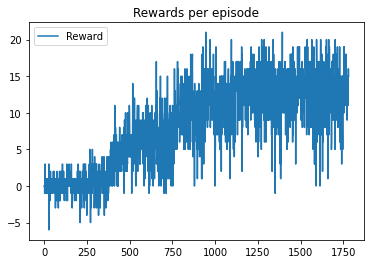

In [24]:
plt.title('Rewards per episode')
plt.plot(agent.rewards_hist, label='Reward')
plt.legend()
plt.savefig('rewards_per_episode.png')
plt.show()

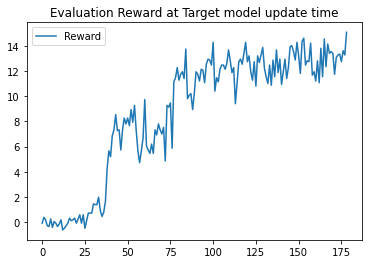

In [23]:
plt.title('Evaluation Reward at Target model update time')
plt.plot(agent.eval_reward_hist, label='Reward')
plt.legend()
plt.savefig('eval_hist.png')
plt.show()

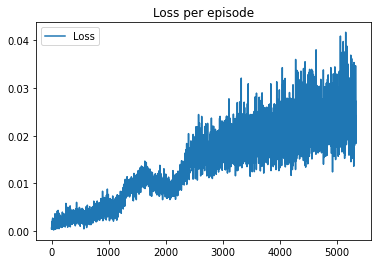

In [25]:
plt.title('Loss per episode')
plt.plot(agent.loss_hist, label='Loss')
plt.legend()
plt.savefig('loss_per_episode.png')
plt.show()

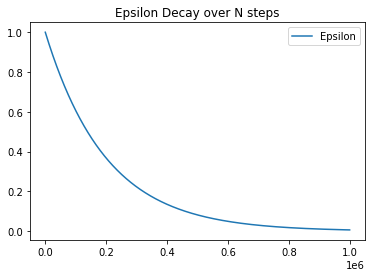

In [26]:
def epsilon_decay(initial, decay, minimum, over=100_000):
    epsilon = initial
    result = []
    for i in range(over):
        epsilon = max(epsilon * decay, minimum)
        result.append(epsilon)
    return result

decay = epsilon_decay(1.0, agent.decay, agent.eps_min, over=1_000_000)

plt.title('Epsilon Decay over N steps')
plt.plot(decay, label='Epsilon')
plt.legend()
plt.savefig('eps_decay.png')
plt.show()

In [22]:
agent.save()

In [ ]:
env.close()